In [2]:
import numpy as np
import pandas as pd
import re

from collections import Counter
import string

import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Dropout
from keras.layers import Input
from keras.optimizers import Adam
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from keras.losses import SparseCategoricalCrossentropy
from keras import Model

from keras_contrib.layers import CRF
# from sklearn_crfsuite import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

from konlpy.tag import Kkma
from konlpy.tag import Mecab
from konlpy.utils import pprint
from konlpy.tag import Twitter,Okt

from transformers import BertModel
# from tokenization_kobert import KoBertTokenizer

import os

from tqdm import tqdm

In [3]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [4]:
okt = Okt()

In [5]:
path_ = r"C:\Users\user\Documents\DL_project\NER"
file_list = os.listdir(path_)
file_list_xlsx = [f for f in file_list if f.endswith(".xlsx")]
file_list_xlsx

['air.xlsx', 'air_pro.xlsx', 'buds.xlsx', 'buds_live.xlsx', 'buds_plus.xlsx']

In [6]:
for f in file_list_xlsx:
    file_path = path_ + "\\" + f
    name = f.replace(".xlsx","")
    globals () ["df_{}".format(name)] =  pd.read_excel(file_path, sheet_name="Sheet2", index_col = 0)

In [7]:
df_buds_live.head()

,word,rule_label,IOB,sentence,enter,review,pos
0,☆☆,O,NaN,0,0,0,Foreign
1,나름,O,NaN,0,0,0,Noun
2,음향,SQ,B,0,0,0,Noun
3,기기,O,NaN,0,0,0,Noun
4,좋아하다,O,NaN,0,0,0,Adjective


In [8]:
def NER_generator(df):
    df["IOB"] = df["IOB"].fillna("O")
    df["rule_label"] = df.rule_label.replace("O","")
    df["NER"] = df["IOB"] + "-" + df["rule_label"]
    df["NER"] = df.NER.replace("O-","O")

In [9]:
NER_generator(df_buds_live)

In [10]:
df_buds_live

,word,rule_label,IOB,sentence,enter,review,pos,NER
0,☆☆,,O,0,0,0,Foreign,O
1,나름,,O,0,0,0,Noun,O
2,음향,SQ,B,0,0,0,Noun,B-SQ
3,기기,,O,0,0,0,Noun,O
4,좋아하다,,O,0,0,0,Adjective,O
...,...,...,...,...,...,...,...,...
18506,가,,O,1044,776,40,Josa,O
18507,훨씬,,O,1044,776,40,Adverb,O
18508,좋다,,O,1044,776,40,Adjective,O
18509,거,,O,1044,776,40,Noun,O


In [11]:
elw = df_buds_live.groupby('enter').count()
iqr = elw['word'].describe()
iqr

count    777.000000
mean      23.823681
std       31.254502
min        1.000000
25%        7.000000
50%       14.000000
75%       26.000000
max      362.000000
Name: word, dtype: float64

In [12]:
iqr_v = iqr['75%'] - iqr['25%']
iqr['75%'] + 1.5* iqr_v

54.5

{'whiskers': [<matplotlib.lines.Line2D at 0x21518b5a850>,
 'caps': [<matplotlib.lines.Line2D at 0x21518b5af10>,
 'boxes': [<matplotlib.lines.Line2D at 0x21518b5a4f0>],
 'medians': [<matplotlib.lines.Line2D at 0x21579ea7610>],
 'fliers': [<matplotlib.lines.Line2D at 0x21579ea7970>],
 'means': []}

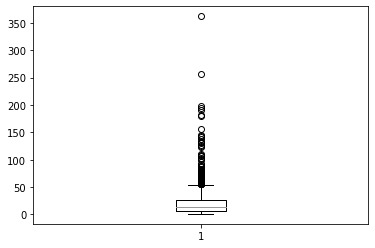

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot(elw['word'])

In [14]:
elw = df_buds_live.groupby('enter').count()
slw = df_buds_live.groupby('sentence').count()

In [15]:
elw

,word,rule_label,IOB,sentence,review,pos,NER
enter,,,,,,,
0,14,14,14,14,14,14,14
1,54,54,54,54,54,54,54
2,31,31,31,31,31,31,31
3,19,19,19,19,19,19,19
4,19,19,19,19,19,19,19
...,...,...,...,...,...,...,...
772,63,63,63,63,63,63,63
773,10,10,10,10,10,10,10
774,13,13,13,13,13,13,13


In [16]:
length = df_buds_live['enter'].unique()

In [17]:
func = lambda temp: [(w, t) for w, t in zip(temp["word"].values.tolist(), temp["NER"].values.tolist())]
tagged_sentences=[t for t in df_buds_live.groupby("enter").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 777


In [18]:
tagged_sentences[57]

[('현', 'O'),
 ('존', 'O'),
 ('시장', 'O'),
 ('에', 'O'),
 ('나오다', 'O'),
 ('블투', 'O'),
 ('이어폰', 'O'),
 ('들', 'O'),
 ('중', 'O'),
 ('에서는', 'O'),
 ('음질', 'B-SQ'),
 ('면', 'O'),
 ('에서', 'O'),
 ('나름', 'O'),
 ('상급', 'O'),
 ('티어', 'O'),
 ('라고', 'O'),
 ('보다', 'O'),
 ('무방', 'O'),
 ('하다', 'O'),
 ('듯', 'O'),
 ('(', 'O'),
 ('N', 'O'),
 ('400', 'O'),
 ('이', 'O'),
 ('블투중', 'O'),
 ('음질', 'B-SQ'),
 ('이', 'O'),
 ('차다', 'O'),
 ('좋다', 'O'),
 ('하다', 'O'),
 ('안', 'O'),
 ('들다', 'O'),
 ('보다', 'O'),
 ('모르다', 'O'),
 ('개인', 'O'),
 ('적', 'O'),
 ('으로', 'O'),
 ('아이팟', 'O'),
 ('프로', 'B-COM'),
 ('보다는', 'O'),
 ('더', 'O'),
 ('좋다', 'O'),
 ('생각', 'O'),
 (')', 'O'),
 ('그리고', 'O'),
 ('커널', 'B-FIT'),
 ('형', 'I-FIT'),
 ('도', 'O'),
 ('아니다', 'O'),
 ('오픈', 'B-FIT'),
 ('형', 'I-FIT'),
 ('이어폰', 'O'),
 ('이다', 'O'),
 ('불구', 'O'),
 ('하고', 'O'),
 ('풍부하다', 'B-SQ'),
 ('중', 'O'),
 ('저음', 'B-SQ'),
 ('부스트', 'O'),
 ('를', 'O'),
 ('제', 'O'),
 ('공함', 'O'),
 ('.', 'O'),
 ('중', 'B-SQ'),
 ('저음', 'I-SQ'),
 ('이', 'O'),
 ('꽤', 'O'),
 ('나', 'O'),
 ('훌륭하다'

In [19]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [20]:
print(sentences[0])
print(ner_tags[0])

['☆☆', '나름', '음향', '기기', '좋아하다', '일반', '유저', '의', '매우', '상세', '한', '리뷰', '작성', '☆☆']
['O', 'O', 'B-SQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


리뷰의 최대 길이 : 362


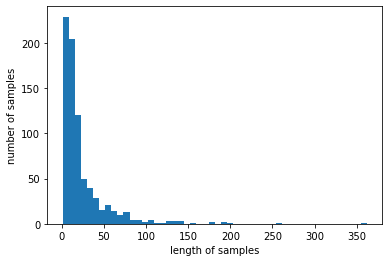

In [21]:
print('리뷰의 최대 길이 : %d' % max(len(l) for l in tagged_sentences))
plt.hist([len(s) for s in tagged_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [23]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 2727
개체명 태깅 정보 집합의 크기 : 44


In [24]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [25]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [26]:
print(X_train[0])
print(y_train[0])

[549, 108, 378, 138, 156, 251, 379, 24, 114, 1485, 37, 139, 1033, 549]
[1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [28]:
print(index_to_ner)

{1: 'O', 2: 'B-FIT', 3: 'B-SQ', 4: 'I-FIT', 5: 'B-NC', 6: 'B-DE', 7: 'B-COM', 8: 'I-NC', 9: 'I-SQ', 10: 'B-PAR', 11: 'B-TK', 12: 'I-TK', 13: 'I-COM', 14: 'B-CNV', 15: 'I-DE', 16: 'B-CAQ', 17: 'B-PR', 18: 'B-CMP', 19: 'B-CA', 20: 'B-BAT', 21: 'I-PAR', 22: 'I-CAQ', 23: 'I-CNV', 24: 'I-CMP', 25: 'I-BAT', 26: 'O-SQ', 27: 'B-AS', 28: 'I-PR', 29: 'B-WEI', 30: 'O-OOOOO', 31: 'O-FIT', 32: 'I-AS', 33: 'B-FA', 34: 'B-', 35: 'O-CMP', 36: 'O-CNV', 37: 'I-CA', 38: 'I-WEI', 39: 'N-NC', 40: 'O-DE', 41: 'O-PR', 42: 'O-PAR', 43: 'I-', 0: 'PAD'}


In [29]:
decoded = []
for index in X_train[5] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(sentences[5]))
print('디코딩 문장 : {}'.format(decoded))

기존 문장 : ['《', '인트', '로', '》']
디코딩 문장 : ['《', '인트', '로', '》']


In [30]:
max_len = 70
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [32]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [33]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (621, 70)
훈련 샘플 레이블의 크기 : (621, 70, 44)
테스트 샘플 문장의 크기 : (156, 70)
테스트 샘플 레이블의 크기 : (156, 70, 44)


In [34]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
# 실제값
predicted=['O'] * len(true) #실제값의 길이만큼 전부 'O'로 채워진 리스트 생성. 예측값으로 사용.
print(predicted)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [35]:
hit = 0 # 정답 개수
for t, p in zip(true, predicted):
    if t == p:
        hit +=1 # 정답인 경우에만 +1
accuracy = hit/len(true) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


In [36]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [37]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']

print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



In [38]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

In [39]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True ):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
        result = []
        for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
            tag = []
            for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
                pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
                tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
            result.append(tag)
        return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):
        print(self.validation_data)
#         #char Embedding을 사용하는 경우
#         if self.use_char:
#             X_test = self.validation_data[0]
#             X_char_test = self.validation_data[1]
#             y_test = self.validation_data[2]
#             y_predicted = self.model.predict([X_test, X_char_test])

#         else:
#             X_test = self.validation_data[0]
#             y_test = self.validation_data[1]
#             y_predicted = self.model.predict([X_test])

#         pred_tags = self.sequences_to_tags(y_predicted)
#         test_tags = self.sequences_to_tags(y_test)

#         score = f1_score(pred_tags, test_tags)
#         print(' - f1: {:04.2f}'.format(score * 100))
#         print(classification_report(test_tags, pred_tags))

#         # F1-score가 지금까지 중 가장 높은 경우
#         if score > self.value:
#             print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
#             self.model.save('best_model.h5')
#             self.value = score
#         else:
#             print('f1_score did not improve from %f'%(self.value))

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

In [44]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.1)#, callbacks=[F1score(use_char=False)])

Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 1.1188 - accuracy: 0.6662 - val_loss: 0.9260 - val_accuracy: 0.8742
Epoch 2/50
5/5 [==============================] - 1s 261ms/step - loss: 0.7188 - accuracy: 0.8721 - val_loss: 0.4535 - val_accuracy: 0.8742
Epoch 3/50
5/5 [==============================] - 1s 281ms/step - loss: 0.4211 - accuracy: 0.8721 - val_loss: 0.3210 - val_accuracy: 0.8742
Epoch 4/50
5/5 [==============================] - 2s 331ms/step - loss: 0.3211 - accuracy: 0.8721 - val_loss: 0.2667 - val_accuracy: 0.8742
Epoch 5/50
5/5 [==============================] - 2s 390ms/step - loss: 0.2856 - accuracy: 0.8721 - val_loss: 0.2522 - val_accuracy: 0.8742
Epoch 6/50
5/5 [==============================] - 2s 375ms/step - loss: 0.2651 - accuracy: 0.8721 - val_loss: 0.2347 - val_accuracy: 0.8742
Epoch 7/50
5/5 [==============================] - 2s 450ms/step - loss: 0.2554 - accuracy: 0.8721 - val_loss: 0.2296 - val_accuracy: 0.8742
Epoch 8/50
5/5 [=======

In [46]:
# bilstm_model = load_model('best_model.h5')

In [52]:
i=54 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
(                : O       O
노이즈              : B-NC    B-NC
켄                : I-NC    O
슬링               : I-NC    O
)                : O       O
생각               : O       O
보다               : O       O
차단               : B-NC    B-NC
이                : O       O
100              : O       O
프로               : O       I-COM
안되다              : O       O
.                : O       O
바깥               : O       O
소리               : O       O
가                : O       O
웅웅               : O       O
울리다              : O       O
들리다              : O       O
.                : O       O


In [48]:
f1score = F1score()

y_predicted = model.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted)
test_tags = f1score.sequences_to_tags(y_test)

In [49]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

          AS       0.00      0.00      0.00         3
         BAT       0.00      0.00      0.00        11
          CA       0.00      0.00      0.00         7
         CAQ       0.18      0.30      0.22        10
         CMP       0.00      0.00      0.00        14
         CNV       0.00      0.00      0.00         7
         COM       0.37      0.56      0.44        27
          DE       0.67      0.46      0.55        39
          FA       0.00      0.00      0.00         3
         FIT       0.84      0.81      0.83        96
          NC       0.56      0.81      0.67        27
         PAR       0.17      0.07      0.10        15
          PR       0.50      0.22      0.31         9
          SQ       0.73      0.70      0.71        50
          TK       0.33      0.43      0.38         7
         WEI       0.00      0.00      0.00         3

   micro avg       0.62      0.54      0.58       328
   macro avg       0.27   

C:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: O-SQ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: O-OOOOO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: O-CMP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: O-FIT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn